# Train and Test Model for predicting customer who are likely to purchase in next 7 days


In [2]:
import pandas as pd
import sagemaker
from sklearn.cluster import KMeans

In [3]:
sess = sagemaker.Session()
region = sess.boto_region_name
bucket = sess.default_bucket()
bucket

'sagemaker-ap-south-1-659144925604'

### Data is stored in S3 bucket and read here

In [4]:
folder='kaggle'
data_key = 'transactions_train.csv'
data_location = 's3://{}/{}/{}'.format(bucket, folder,data_key)
pd.set_option('max_colwidth', 100)  # default is 50
df = pd.read_csv(data_location)
pd.set_option('max_colwidth', 100)  # default is 50
# #df = pd.read_csv("fm_preprocessed.csv")
# df["detail_desc"].fillna("", inplace=True)

# # The list of top customers (customers with the most product reviews).
# df.groupby("customer_id").count()["article_id"].sort_values(ascending=False).head(30)

In [5]:
tx_data=df
tx_data


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699338c5570910a014cc2,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f99982410630ac51314356,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f99982410630ac51314356,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e6936f26ea7ecaa68a1,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e593881ae6007d775f0f,833459002,0.006763,1


In [6]:
tx_data.shape

(31788324, 5)

In [7]:
tx_data.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [11]:
print("Unique customers  = ",tx_data.customer_id.unique().size)
print("Unique Products = ",tx_data.article_id.unique().size)

Unique customers  =  1362281
Unique Products =  104547


#### converting date of transaction - t_dat to Datetime

In [12]:
tx_data['t_dat'] = pd.to_datetime(tx_data['t_dat'])


#### Since customer id field is ling string which will be problem in training the model, we will replace customer Id with index value and save the dictionary of encoded customer id and index value for future referece. Then we can drop the encoded value

In [13]:
tx_data.rename(columns = {'customer_id':'customer_id_encoded'}, inplace = True)
tx_user = pd.DataFrame(tx_data['customer_id_encoded'].unique())
tx_user.columns = ['customer_id_encoded']
tx_user['customer_id'] = tx_user.index+1
tx_customer_index_mapping=tx_user[['customer_id','customer_id_encoded']]
tx_customer_index_mapping.to_csv('customer_mapping.csv')
tx_data = pd.merge(tx_data,tx_customer_index_mapping,on='customer_id_encoded',how='left')

In [14]:
tx_data=tx_data.drop("customer_id_encoded",axis=1)

In [15]:
tx_user=tx_user.drop("customer_id_encoded",axis=1)

In [16]:
tx_data.head()

,t_dat,article_id,price,sales_channel_id,customer_id
0,2018-09-20,663713001,0.050831,2,1
1,2018-09-20,541518023,0.030492,2,1
2,2018-09-20,505221004,0.015237,2,2
3,2018-09-20,685687003,0.016932,2,2
4,2018-09-20,685687004,0.016932,2,2


### Read the customer data from customers.csv

In [18]:
customer_key = 'customers.csv'
user_location = 's3://{}/{}/{}'.format(bucket, folder,customer_key)
pd.set_option('max_colwidth', 100)  # default is 50
df_cust = pd.read_csv(user_location)


### replace the encoded customer id with numeric customer id from previous step

In [19]:
tx_mapping=pd.read_csv('./customer_mapping.csv')
df_cust.rename(columns = {'customer_id':'customer_id_encoded'}, inplace = True)
df_cust = pd.merge(df_cust,tx_mapping,on='customer_id_encoded',how='left')
df_cust.head()


,customer_id_encoded,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,Unnamed: 0,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a91f8ca0d4b6efa8100,568616.0,568617.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93f4c830291c32bc3057,13987.0,13988.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6c9090f7dd3e38380dc,0.0,1.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c222539af5973a23ae6d,877559.0,877560.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd4564743b005a805b1d,221115.0,221116.0


In [21]:
df_cust.columns

Index(['customer_id_encoded', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'Unnamed: 0',
       'customer_id'],
      dtype='object')

In [23]:
df_cust.Active.value_counts()

1.0    464404
Name: Active, dtype: int64

In [24]:
df_cust.Active.isna().sum()

907576

### Replace na active as 0 and create a new column called status

In [25]:
df_cust['status'] = df_cust['Active'].fillna(0)

In [26]:
df_cust.status.value_counts()

0.0    907576
1.0    464404
Name: status, dtype: int64

In [27]:
df_cust["fashion_news_frequency"].value_counts()

NONE         877711
Regularly    477416
Monthly         842
None              2
Name: fashion_news_frequency, dtype: int64

### For fashion news frequency replace None with NONE

In [116]:
df_cust["fashion_news_frequency"]=df_cust["fashion_news_frequency"].replace("None", "NONE",regex=True)

In [28]:
df_cust.columns

Index(['customer_id_encoded', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'Unnamed: 0',
       'customer_id', 'status'],
      dtype='object')

In [33]:
df_cust.postal_code.nunique()

352899

### Remove unwanted columns like postal code which has very high cardinality, First Name

In [38]:
col_drop=['postal_code','FN','customer_id_encoded','Unnamed: 0','Active']
df_cust=df_cust.drop(col_drop,axis=1)

In [39]:
df_cust.head()

,club_member_status,fashion_news_frequency,age,customer_id,status
0,ACTIVE,NONE,49.0,568617.0,0.0
1,ACTIVE,NONE,25.0,13988.0,0.0
2,ACTIVE,NONE,24.0,1.0,0.0
3,ACTIVE,NONE,54.0,877560.0,0.0
4,ACTIVE,Regularly,52.0,221116.0,1.0


### Lets do one hot encoding on categorical features - club_member_status, fashion_news_frequency

In [40]:
df_cust=pd.get_dummies(df_cust)

In [41]:
df_cust.columns

Index(['age', 'customer_id', 'status', 'club_member_status_ACTIVE',
       'club_member_status_LEFT CLUB', 'club_member_status_PRE-CREATE',
       'fashion_news_frequency_Monthly', 'fashion_news_frequency_NONE',
       'fashion_news_frequency_None', 'fashion_news_frequency_Regularly'],
      dtype='object')

### checking for any undefined values

In [42]:
df_cust.isna().sum()

age                                 15861
customer_id                          9699
status                                  0
club_member_status_ACTIVE               0
club_member_status_LEFT CLUB            0
club_member_status_PRE-CREATE           0
fashion_news_frequency_Monthly          0
fashion_news_frequency_NONE             0
fashion_news_frequency_None             0
fashion_news_frequency_Regularly        0
dtype: int64

### Lets replace age with the mean age and lets drop any row with na as customer id

In [43]:
df_cust['age'].fillna(df_cust['age'].mean(), inplace=True)

In [46]:
df_cust=df_cust.dropna()
df_cust.isna().sum()

age                                 0
customer_id                         0
status                              0
club_member_status_ACTIVE           0
club_member_status_LEFT CLUB        0
club_member_status_PRE-CREATE       0
fashion_news_frequency_Monthly      0
fashion_news_frequency_NONE         0
fashion_news_frequency_None         0
fashion_news_frequency_Regularly    0
dtype: int64

In [47]:
df_cust.to_csv("user_mapping.csv")

## Lets collect all customer Ids grouped in one data frame and calculate Recency, Frequency And Monetory Score for each customer


# Recency
### recency is defined as how soon a customer purchased. Lower the recency number the better are chances of customer purchasing in next few days. So we will reward the lower recency number with better score

#### We can group data for each customer and find how soon the customer purchased as compared to max purchase date in whiole data set

In [49]:
tx_max_purchase = tx_data.groupby('customer_id').t_dat.max().reset_index()
tx_max_purchase.columns = ['customer_id','MaxPurchaseDate']
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['customer_id','Recency']], on='customer_id')

In [50]:
tx_user

,customer_id,Recency
0,1,7
1,2,132
2,3,174
3,4,8
4,5,160
...,...,...
1362276,1362277,0
1362277,1362278,0
1362278,1362279,0
1362279,1362280,0


In [51]:
tx_user.Recency.describe()

count    1.362281e+06
mean     2.351484e+02
std      2.211188e+02
min      0.000000e+00
25%      4.800000e+01
50%      1.510000e+02
75%      3.980000e+02
max      7.330000e+02
Name: Recency, dtype: float64

### We have recency number.Now we can create clusters from these recency numbers and try to assign a score against each cluster. Remember lower recency number will be rewarded with a better score

#### Lets run KMeans on Recency numbers and cluster them in unique clusters

In [52]:
from sklearn.cluster import KMeans


In [53]:
!pip install matplotlib
import matplotlib.pyplot as plt

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


#### Identify optimum number of clusters from 1-10

In [54]:

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    #tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 


#### Lets visualise the cluster number against the loss

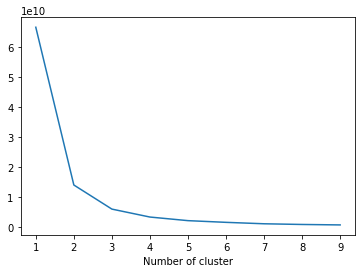

In [55]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### number of clusters can be choosen as much 4

In [56]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [57]:
tx_user.RecencyCluster.unique()

array([0, 3, 2, 1], dtype=int32)

#### Defining a utility function to order the cluster number against the score. 

In [58]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [59]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [60]:
tx_user.groupby('RecencyCluster')['Recency'].describe()
tx_user['RecencyCluster'].unique()

array([3, 2, 0, 1])

# Frequency
#### The Frequency is defined as how often the customer purchases. Higher the number the higher is the score for the customer

In [61]:
tx_frequency = tx_data.groupby('customer_id').t_dat.count().reset_index()
tx_frequency.columns = ['customer_id','Frequency']
tx_frequency.head()

,customer_id,Frequency
0,1,18
1,2,120
2,3,27
3,4,61
4,5,57


In [62]:
tx_user = pd.merge(tx_user, tx_frequency, on='customer_id')

In [63]:
tx_user.Frequency.describe()

count    1.362281e+06
mean     2.333463e+01
std      3.924225e+01
min      1.000000e+00
25%      3.000000e+00
50%      9.000000e+00
75%      2.700000e+01
max      1.895000e+03
Name: Frequency, dtype: float64

#### Lets run K means on the frequency number and try to find the optimum number of clusters

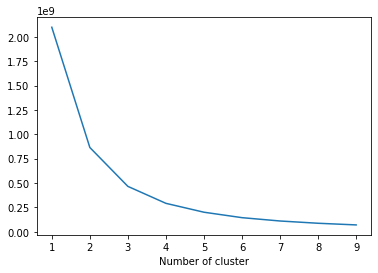

In [64]:
sse_freq={}
tx_freq= tx_user[['Frequency']]
for k in range(1, 10):
    kmeans_freq = KMeans(n_clusters=k, max_iter=1000).fit(tx_freq)
    #tx_freq["clusters"] = kmeans_freq.labels_
    sse_freq[k] = kmeans_freq.inertia_ 
plt.figure()
plt.plot(list(sse_freq.keys()), list(sse_freq.values()))
plt.xlabel("Number of cluster")
plt.show()


In [65]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [66]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,251206.0,49.130379,16.067322,29.0,35.0,45.0,60.0,88.0
1,1039846.0,8.389801,7.267233,1.0,3.0,6.0,13.0,28.0
2,62454.0,128.112899,33.020641,89.0,101.0,119.0,148.0,219.0
3,8775.0,310.109858,108.491328,220.0,242.0,276.0,338.0,1895.0


In [67]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [68]:
tx_user.head()

,customer_id,Recency,RecencyCluster,Frequency,FrequencyCluster
0,1,7,3,18,0
1,25,16,3,17,0
2,30,54,3,16,0
3,34,7,3,16,0
4,37,93,3,24,0


# Monetary Value
### Total money spend by customer will contribute to monetary score. More the total spend more is the revenue score . Lets calculate the Monetary value of each customer

In [69]:
tx_revenue = tx_data.groupby('customer_id').price.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='customer_id')
tx_user.price.describe()

count    1.362281e+06
mean     6.493858e-01
std      1.197582e+00
min      7.627119e-04
25%      8.806780e-02
50%      2.455932e-01
75%      7.011864e-01
max      5.767641e+01
Name: price, dtype: float64

In [70]:
tx_user.head()

,customer_id,Recency,RecencyCluster,Frequency,FrequencyCluster,price
0,1,7,3,18,0,0.704780
1,25,16,3,17,0,0.872593
2,30,54,3,16,0,0.456186
3,34,7,3,16,0,0.410322
4,37,93,3,24,0,0.729339


#### Again running K-means on the total price number and create optimum number of cluster. Then we can align each price total to a score

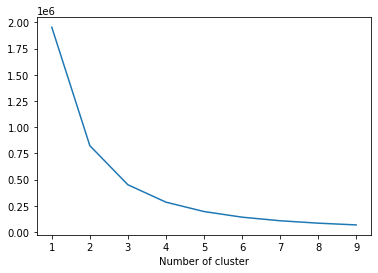

In [71]:
sse={}
tx_revenue = tx_user[['price']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    #tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [72]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['price']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['price']])

In [73]:
tx_user = order_cluster('RevenueCluster', 'price',tx_user,True)

In [74]:
tx_user.groupby('RevenueCluster')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1091711.0,0.247928,0.224974,0.000763,0.068610,0.164797,0.368407,0.899017
1,214953.0,1.552148,0.525924,0.899034,1.111169,1.413525,1.897186,2.897576
2,48707.0,4.250057,1.139336,2.897593,3.321907,3.924881,4.932373,7.423254
3,6910.0,10.612791,3.940668,7.423966,8.206381,9.342881,11.574021,57.676407


#### Lets try to identify for each customer for every purchase transaction record what were the previous 3 purchase dates

#### For each transaction order keep the customer id and transaction date and sort for each customer id and transaction date. Drop the duplicates

In [75]:
tx_day_order = tx_data[['customer_id','t_dat']]
tx_day_order['InvoiceDay'] = tx_data['t_dat'].dt.date
tx_day_order = tx_day_order.sort_values(['customer_id','t_dat'])
tx_day_order = tx_day_order.drop_duplicates(subset=['customer_id','InvoiceDay'],keep='first')

<ipython-input-75-1cb900ec3fdc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_day_order['InvoiceDay'] = tx_data['t_dat'].dt.date


#### Now for each customer record Identify Previous 3 transaction dates.

In [77]:
#shifting last 3 purchase dates
tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('customer_id')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('customer_id')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('customer_id')['InvoiceDay'].shift(3)

### We are interested in the difference between days
### DayDiff is the differnece of days after which customer made the current purchase
#### DayDiff2 is difference of days from current to previous to last and Similarly DayDiff3 is diff of current with previous to previous to last

In [78]:
tx_day_order['DayDiff'] = (tx_day_order['InvoiceDay'] - tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['T3InvoiceDate']).dt.days

In [79]:
tx_day_diff= tx_day_order[['customer_id','DayDiff2', 'DayDiff3','DayDiff']].reset_index()

If th customer has not made atleast 4 transactions then we would have na on DayDiff3 or other DayDiff columns. We can simply drop these records

In [80]:
tx_day_diff.isna().sum()

index                0
customer_id          0
DayDiff2       2276589
DayDiff3       3007781
DayDiff        1362281
dtype: int64

In [81]:
tx_day_diff.shape

(9080179, 5)

In [82]:
tx_day_diff.dropna().shape

(6072398, 5)

In [83]:
tx_day_diff=tx_day_diff.dropna()


In [84]:
tx_day_diff.isna().sum()

index          0
customer_id    0
DayDiff2       0
DayDiff3       0
DayDiff        0
dtype: int64

In [85]:
tx_day_diff.columns

Index(['index', 'customer_id', 'DayDiff2', 'DayDiff3', 'DayDiff'], dtype='object')

### Lets merge this DayDiff columns with the user data

In [86]:
tx_user = pd.merge(tx_user, tx_day_diff[['customer_id','DayDiff','DayDiff2','DayDiff3']], on='customer_id')


In [87]:
tx_user.columns


Index(['customer_id', 'Recency', 'RecencyCluster', 'Frequency',
       'FrequencyCluster', 'price', 'RevenueCluster', 'DayDiff', 'DayDiff2',
       'DayDiff3'],
      dtype='object')

In [88]:
tx_user.isna().sum()

customer_id         0
Recency             0
RecencyCluster      0
Frequency           0
FrequencyCluster    0
price               0
RevenueCluster      0
DayDiff             0
DayDiff2            0
DayDiff3            0
dtype: int64

### lets drop the correlated columns. since we calculated the score against the Recency, Frequency and price already we dont need this columns as they are now corelated

In [89]:
columnsToDrop=['Recency','Frequency','price']

In [90]:
tx_user=tx_user.drop(columnsToDrop,axis=1)

#### previously we had collected the user metadata. We can merge this data with tx_user. Lets name the new data set as cust_attributes.

In [91]:
cust_attributes = pd.merge(tx_user, df_cust, on='customer_id')
cust_attributes=cust_attributes.drop('customer_id',axis=1)

In [92]:
cust_attributes

,RecencyCluster,FrequencyCluster,RevenueCluster,DayDiff,DayDiff2,DayDiff3,age,status,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_NONE,fashion_news_frequency_None,fashion_news_frequency_Regularly
0,3,0,0,339.0,497.0,501.0,24.0,0.0,1,0,0,0,1,0,0
1,3,0,0,58.0,397.0,555.0,24.0,0.0,1,0,0,0,1,0,0
2,3,0,0,17.0,75.0,414.0,24.0,0.0,1,0,0,0,1,0,0
3,3,0,0,150.0,167.0,225.0,24.0,0.0,1,0,0,0,1,0,0
4,3,0,0,87.0,122.0,216.0,23.0,1.0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6072393,1,3,3,1.0,5.0,10.0,64.0,1.0,1,0,0,0,0,0,1
6072394,1,3,3,3.0,4.0,8.0,64.0,1.0,1,0,0,0,0,0,1
6072395,1,3,3,3.0,6.0,7.0,64.0,1.0,1,0,0,0,0,0,1
6072396,1,3,3,1.0,4.0,7.0,64.0,1.0,1,0,0,0,0,0,1


In [93]:
cust_attributes.isna().sum()

RecencyCluster                      0
FrequencyCluster                    0
RevenueCluster                      0
DayDiff                             0
DayDiff2                            0
DayDiff3                            0
age                                 0
status                              0
club_member_status_ACTIVE           0
club_member_status_LEFT CLUB        0
club_member_status_PRE-CREATE       0
fashion_news_frequency_Monthly      0
fashion_news_frequency_NONE         0
fashion_news_frequency_None         0
fashion_news_frequency_Regularly    0
dtype: int64

In [94]:
cust_attributes.head()

,RecencyCluster,FrequencyCluster,RevenueCluster,DayDiff,DayDiff2,DayDiff3,age,status,club_member_status_ACTIVE,club_member_status_LEFT CLUB,club_member_status_PRE-CREATE,fashion_news_frequency_Monthly,fashion_news_frequency_NONE,fashion_news_frequency_None,fashion_news_frequency_Regularly
0,3,0,0,339.0,497.0,501.0,24.0,0.0,1,0,0,0,1,0,0
1,3,0,0,58.0,397.0,555.0,24.0,0.0,1,0,0,0,1,0,0
2,3,0,0,17.0,75.0,414.0,24.0,0.0,1,0,0,0,1,0,0
3,3,0,0,150.0,167.0,225.0,24.0,0.0,1,0,0,0,1,0,0
4,3,0,0,87.0,122.0,216.0,23.0,1.0,1,0,0,0,0,0,1


#### Here DayDiff becomes our target column. We can interpret this in a way that Given some customer attributes like RFM scores, age, statuses, membership status, difference of days of last 2 transactions, what will be the next number of days that customer is likely to purchase (In our case that lebel is DayDiff)

#### But instead of identifying as Regression problem we can also consider this as a classification problem and identify label , if DayDiff is <=7 then label is 1 otherwise 0. So the model will try to learn and predict this label

#### lets call the label as CustomerBuyNext7Days

In [95]:
cust_attributes['CustomerBuyNext7days'] = 1
cust_attributes.loc[cust_attributes.DayDiff>7,'CustomerBuyNext7days'] = 0


#### Lets see the distribution of the labels

In [96]:
cust_attributes.CustomerBuyNext7days.value_counts()/len(cust_attributes)

0    0.715902
1    0.284098
Name: CustomerBuyNext7days, dtype: float64

#### We dont need the DayDiff column anymore

In [97]:
cust_attributes=cust_attributes.drop('DayDiff',axis=1)

#### lets see correlation of multiple attributes of the data

<AxesSubplot:>

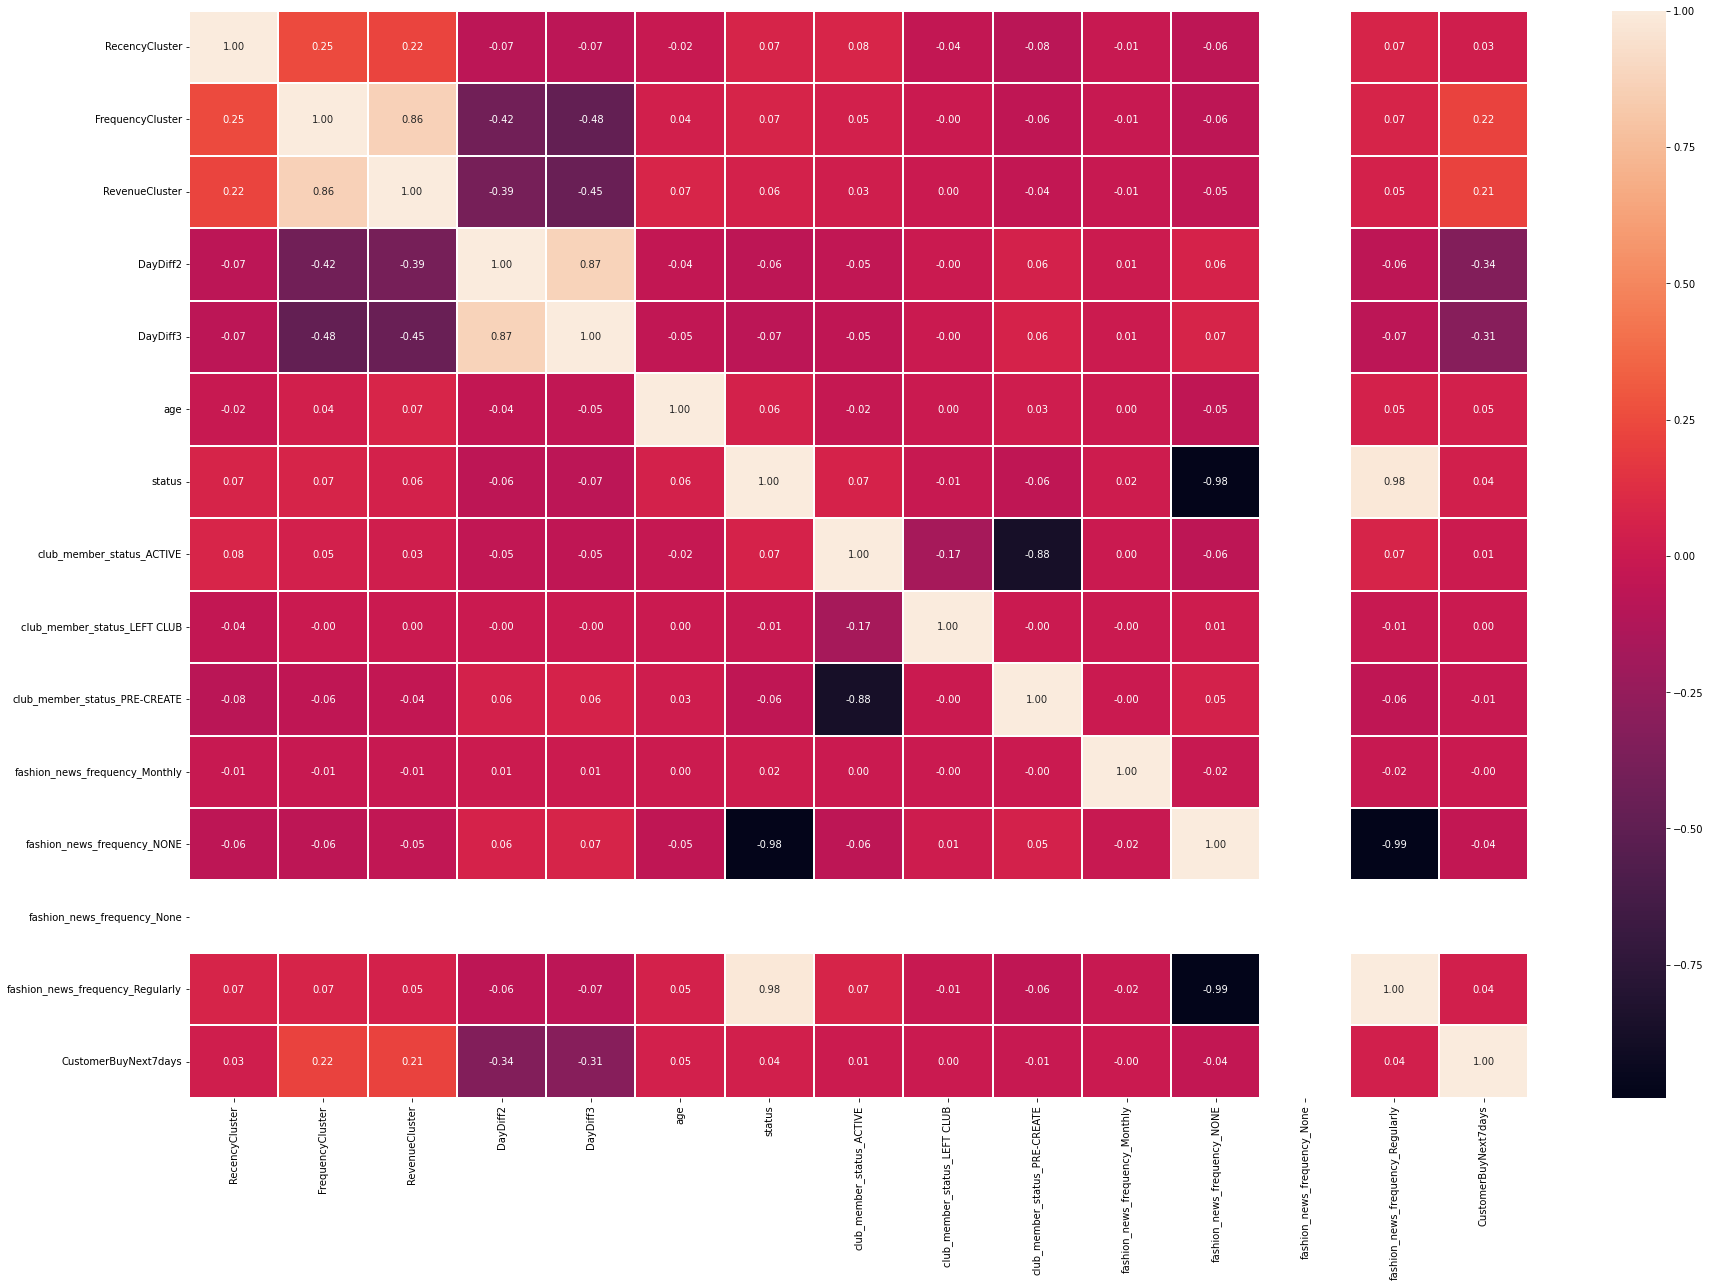

In [98]:
import seaborn as sns
corr = cust_attributes[cust_attributes.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

#### We can drop fashion_news_frequencyz-none as it is redundant ansd highly corelated, club_memeber_status_pre_create

In [99]:
cust_attributes=cust_attributes.drop(['fashion_news_frequency_NONE','club_member_status_PRE-CREATE'],axis=1)

#### Split dataset using sklearn train_test_split

In [100]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [101]:
X, y = cust_attributes.drop('CustomerBuyNext7days',axis=1), cust_attributes.CustomerBuyNext7days

In [102]:
X

,RecencyCluster,FrequencyCluster,RevenueCluster,DayDiff2,DayDiff3,age,status,club_member_status_ACTIVE,club_member_status_LEFT CLUB,fashion_news_frequency_Monthly,fashion_news_frequency_None,fashion_news_frequency_Regularly
0,3,0,0,497.0,501.0,24.0,0.0,1,0,0,0,0
1,3,0,0,397.0,555.0,24.0,0.0,1,0,0,0,0
2,3,0,0,75.0,414.0,24.0,0.0,1,0,0,0,0
3,3,0,0,167.0,225.0,24.0,0.0,1,0,0,0,0
4,3,0,0,122.0,216.0,23.0,1.0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6072393,1,3,3,5.0,10.0,64.0,1.0,1,0,0,0,1
6072394,1,3,3,4.0,8.0,64.0,1.0,1,0,0,0,1
6072395,1,3,3,6.0,7.0,64.0,1.0,1,0,0,0,1
6072396,1,3,3,4.0,7.0,64.0,1.0,1,0,0,0,1


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=44)

In [104]:
y

0          0
1          0
2          0
3          0
4          0
          ..
6072393    1
6072394    1
6072395    1
6072396    1
6072397    0
Name: CustomerBuyNext7days, Length: 6072398, dtype: int64

In [105]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, random_state=44)

In [106]:
X_train.shape

(4645384, 12)

In [107]:
X_val.shape

(516154, 12)

In [108]:
X_test.shape

(910860, 12)

#### Apply Normalization on  Age, DayDiff2 and DayDiff3

In [109]:
from sklearn.preprocessing import MinMaxScaler 
minmaxscaler_age = MinMaxScaler() 
minmaxscaler_age.fit(X_train[['age']]) 
X_train['age'] = minmaxscaler_age.transform(X_train[['age']])
X_val['age'] = minmaxscaler_age.transform(X_val[['age']])
X_test['age'] = minmaxscaler_age.transform(X_test[['age']])
minmaxscaler_daydiff2 = MinMaxScaler() 
minmaxscaler_daydiff2.fit(X_train[['DayDiff2']]) 
X_train['DayDiff2'] = minmaxscaler_daydiff2.transform(X_train[['DayDiff2']])
X_val['DayDiff2'] = minmaxscaler_daydiff2.transform(X_val[['DayDiff2']])
X_test['DayDiff2'] = minmaxscaler_daydiff2.transform(X_test[['DayDiff2']])
minmaxscaler_daydiff3 = MinMaxScaler() 
minmaxscaler_daydiff3.fit(X_train[['DayDiff3']]) 
X_train['DayDiff3'] = minmaxscaler_daydiff3.transform(X_train[['DayDiff3']])
X_val['DayDiff3'] = minmaxscaler_daydiff3.transform(X_val[['DayDiff3']])
X_test['DayDiff3'] = minmaxscaler_daydiff3.transform(X_test[['DayDiff3']])


<ipython-input-109-1b015928b95a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['age'] = minmaxscaler_age.transform(X_test[['age']])
<ipython-input-109-1b015928b95a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['DayDiff2'] = minmaxscaler_daydiff2.transform(X_test[['DayDiff2']])
<ipython-input-109-1b015928b95a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [110]:
X_train.age.describe()

count    4.645384e+06
mean     2.496723e-01
std      1.650039e-01
min      0.000000e+00
25%      1.084337e-01
50%      1.927711e-01
75%      3.975904e-01
max      1.000000e+00
Name: age, dtype: float64

In [111]:
X_train.DayDiff2.describe()

count    4.645384e+06
mean     1.033032e-01
std      1.118653e-01
min      0.000000e+00
25%      2.904564e-02
50%      6.639004e-02
75%      1.369295e-01
max      1.000000e+00
Name: DayDiff2, dtype: float64

Check the distribution of dayDiff from training and test dataset

/usr/local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:20:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on training set: 0.82
Accuracy of XGB classifier on test set: 0.82


(array([3325649.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0., 1319735.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

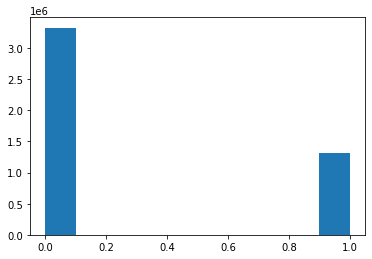

In [188]:
plt.hist(y_train)

In [112]:
!pip install xgboost

  Using cached xgboost-1.5.2-py3-none-manylinux2014_x86_64.whl (173.6 MB)
You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.


In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#### Lets see which classification model gives good precision. I am choosing precision as this may be important metric to calcuate. Precision says that if my model is saying that this customer is likely to purchase in next 7 days then probability of that happening for that prediction is on higher side. So we are trying to minimize False Positives. Since these customers willbe target of marletting campaigns and eligible for offers which means there is investment being done by company on these customers so it is important that precision of prediction is good. So lets try to gauge our models
### We are checking for LogisticRegression, RandomForestClassifier and XGBosst classifer

In [115]:
models = []
models.append(("LR",LogisticRegression()))
#models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
#models.append(("SVC",SVC()))
#models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
#models.append(("KNN",KNeighborsClassifier()))

In [116]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22, shuffle=True)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "precision")
    print(name, cv_result)

LR [0.79841555 0.79732293]
RF [0.66690839 0.66643358]


/usr/local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:21:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:22:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB [0.84195519 0.835694  ]


### XGBoost was the winner so we wil try to train the XGBoost classifier with default values and see the results

In [117]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

/usr/local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:22:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on training set: 0.82
Accuracy of XGB classifier on test set: 0.82


In [118]:
y_pred = xgb_model.predict(X_test)

In [119]:
from sklearn.metrics import classification_report,confusion_matrix


In [120]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89    651518
           1       0.84      0.47      0.60    259342

    accuracy                           0.82    910860
   macro avg       0.83      0.72      0.74    910860
weighted avg       0.82      0.82      0.80    910860



### Lets do some Hyperparameters tuning for our XgBosst model. We will try to iterate in max_depth and min_child_weight hyperparameter and select best options and then train the model with these hyperparameters

In [121]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,15),
 'min_child_weight':range(1,6)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='precision',n_jobs=-1, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 3, 'min_child_weight': 3}, 0.8382847034591455)

In [122]:
xgb_model = xgb.XGBClassifier(max_depth=3,min_child_weight=3).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))



[14:33:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on training set: 0.82
Accuracy of XGB classifier on test set: 0.82


In [123]:
y_pred = xgb_model.predict(X_test)

In [124]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.96      0.89    651518
           1       0.84      0.47      0.60    259342

    accuracy                           0.82    910860
   macro avg       0.83      0.72      0.74    910860
weighted avg       0.82      0.82      0.80    910860



## Lets also try to train a Neural Network model and see how it performs. For this we can use tensor flow with Keras

In [125]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [126]:
## CODE HERE
model = Sequential()

# Remember to compile()
model.add(Dense(11,activation='relu'))
#model.add(Dropout(0.2))  // since model shows no signs of overfit I decided to not use the droput

model.add(Dense(5,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(5,activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam')


In [127]:
model.fit(x=X_train,y=y_train,epochs=25,batch_size=256, 
          validation_data=(X_val,y_val))

Epoch 1/25
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-04-05 14:34:42.035 tensorflow-2-6-cpu-p-ml-m5-4xlarge-0ff1e2c27204253a5437e9d6f1d4:22 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-04-05 14:34:42.086 tensorflow-2-6-cpu-p-ml-m5-4xlarge-0ff1e2c27204253a5437e9d6f1d4:22 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
18147/18147 [==============================] - 45s 2ms/step - loss: 0.4311 - val_loss: 0.4141
Epoch 2/25
18147/18147 [==============================] - 44s 2ms/step - loss: 0.4161 - val_loss: 0.4209
Epoch 3/25
18147/18147 [==============================] - 43s 2ms/step - loss: 0.4154 - val_loss: 0.

#### Lets visualize the training and validation loss.

<AxesSubplot:>

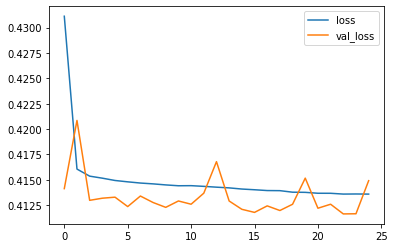

In [128]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

#### We can see that model shows no sign of Overfitting and it performed well on training loss as well. We can later further tune this with multple Hyper paremetrs experimentation

#### Lets predict the result with hold out test set

In [129]:
predictions = model.predict(X_test)

#### convert predictions to binary with threshold as 0.5

In [130]:
pred_com=predictions.copy()


In [131]:
def mapbinary(i):
    if i>=0.5:
        return 1
    return 0
    

In [132]:
import numpy as np
applyall = np.vectorize(mapbinary)

In [133]:
pred_mod=applyall(pred_com)

In [134]:
print(classification_report(y_test,pred_mod))

              precision    recall  f1-score   support

           0       0.81      0.97      0.89    651518
           1       0.87      0.43      0.58    259342

    accuracy                           0.82    910860
   macro avg       0.84      0.70      0.73    910860
weighted avg       0.83      0.82      0.80    910860



#### Looks like we also get good results from neural network model

## Next step would be train a recommendation model for the customers